In [46]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

%matplotlib inline 

In [47]:
# import all pyphysio classes and methods
import pyphysio as ph

In [48]:
# import data and creating a signal
df_BVP = pd.read_csv('BVP_pp3.csv', header=None)

In [49]:
#count rows 
n_of_rows = df_BVP.count()
print(n_of_rows)

0    1048574
dtype: int64


In [51]:
#rows to keep 
n_of_rows_keep = 3540*64
print(n_of_rows_keep) #rows we want to keep 

226560


In [52]:
#using pandas to drop all the rows / seconds after 3720s 
df_BVP = df_BVP.drop(df_BVP.index[226560:1048574])
print(df_BVP)

           0
0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
...      ...
226555 -1.98
226556 -0.48
226557  0.60
226558  1.25
226559  1.49

[226560 rows x 1 columns]


In [53]:
#create BVP signal 
fsamp = 64  #64 Hz 
t_start = 0

ecg = ph.EvenlySignal(values = df_BVP, sampling_freq = fsamp, signal_type = 'ecg')

In [54]:
print(ecg.get_start_time())

0


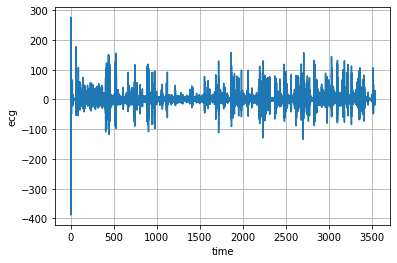

In [55]:
ecg.plot()

In [56]:
ibi = ph.BeatFromECG()(ecg)

In [57]:
ibi.get_duration() #seconds 

3540.0

In [58]:
# create label
label = np.zeros(3540)
label[0:600] = 1
label[600:3540] = 2

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label') 
#sampling_freq here is not intended as real sampfeq, only the distance between one point and the other (e.g. 10 = 10 units between 'begin' & 'end')

In [59]:
# (optional) IIR filtering : remove high frequency noise
#ecg = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)

In [60]:
# normalization : normalize data
ecg = ph.Normalize(norm_method='standard')(ecg)

In [61]:
# resampling : increase the sampling frequency by cubic interpolation
ecg = ecg.resample(fout=4096, kind='cubic')
fsamp = 4096

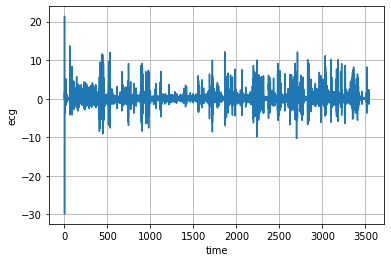

In [62]:
ecg.plot()

In [63]:
ibi = ph.BeatFromECG()(ecg)

In [64]:
ibi.get_duration()


3540.0

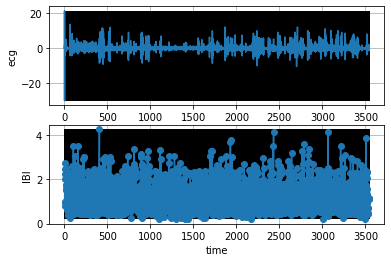

In [65]:
# check results so far
ax1 = plt.subplot(211)
ecg.plot()
plt.vlines(ibi.get_times(), np.min(ecg), np.max(ecg))

plt.subplot(212, sharex = ax1)
ibi.plot('o-')
plt.vlines(ibi.get_times(), np.min(ibi), np.max(ibi))
plt.show()

In [66]:
### physiological indicators 

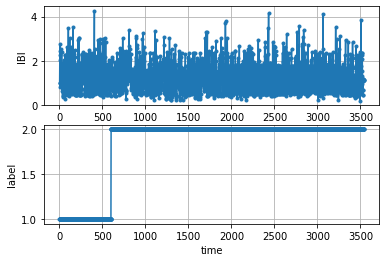

In [67]:
# check label
ax1 = plt.subplot(211)
ibi.plot('.-')

plt.subplot(212, sharex = ax1)
label.plot('.-')
plt.show()

In [68]:
# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]

In [69]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 60, width = 60, labels = label)

indicators, col_names = ph.fmap(fixed_length, hrv_indicators, ibi)

In [70]:
# extract column with the labels for each window
label_w = indicators[:, np.where(col_names == 'label')[0]]

# extract column with the RRmean values computed from each window
rrmean_w = indicators[:, np.where(col_names == 'RRmean')[0]]

rrmean_image1 = rrmean_w[np.where(label_w==1)[0]].ravel()
rrmean_image2 = rrmean_w[np.where(label_w==2)[0]].ravel()

{'whiskers': [<matplotlib.lines.Line2D at 0x1c26905110>,
 'caps': [<matplotlib.lines.Line2D at 0x1c26905bd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c26908510>,
 'medians': [<matplotlib.lines.Line2D at 0x1c268fe650>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c268feb50>,
 'means': []}

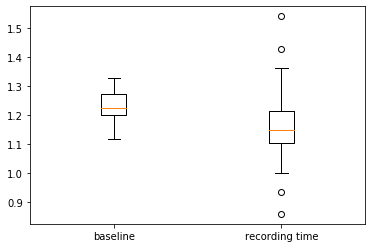

In [71]:
## create a box and whisker plot to compare the distibution of the RRmean indicator
plt.boxplot([rrmean_image1, rrmean_image2],
            labels=['baseline', 'recording time'])

In [72]:
HRV_FD = ph.preset_hrv_fd() #frequency domain HRV indicators
print(HRV_FD)

print(HRV_FD[0].get())

[IBI_VLF_Pow, IBI_LF_Pow, IBI_HF_Pow, IBI_Total_Pow]
{'freq_min': 1e-05, 'freq_max': 0.04, 'method': 'ar', 'interp_freq': 4, 'name': 'IBI_VLF_Pow'}


In [73]:
FD_HRV_ind, col_names = ph.fmap(fixed_length, ph.preset_hrv_fd(), ibi.resample(4))

In [74]:
import pandas as pd

# create a pandas dataframe
FD_HRV_pp1_df = pd.DataFrame(FD_HRV_ind, columns=col_names)

FD_HRV_pp1_df

,begin,end,label,IBI_VLF_Pow,IBI_LF_Pow,IBI_HF_Pow,IBI_Total_Pow
0,1.227783,61.227783,1.0,445.667392,463.747794,833.230381,2454.733974
1,61.227783,121.227783,1.0,266.224011,652.028924,823.773380,2482.704260
2,121.227783,181.227783,1.0,144.455374,488.278342,846.931552,2163.581006
3,181.227783,241.227783,1.0,207.481569,479.196573,651.643013,1973.675627
4,241.227783,301.227783,1.0,242.502470,596.188120,849.186649,2392.717546
5,301.227783,361.227783,1.0,177.989829,486.937151,762.826475,2157.018987
6,361.227783,421.227783,1.0,211.799871,630.170613,817.598729,2389.823435
7,421.227783,481.227783,1.0,115.586874,405.800268,909.313757,2118.789424
8,481.227783,541.227783,1.0,224.428874,703.312620,956.335095,2546.482437
9,601.227783,661.227783,2.0,234.639152,580.772438,814.294736,2302.550584


In [75]:
#save data 
FD_HRV_pp1_df.to_csv('FD_HRV_pp3.csv')